# IMPORT PACKAGES

In [56]:
pip install imutils


Note: you may need to restart the kernel to use updated packages.


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import cv2
import os
from xgboost import XGBClassifier
import random
import matplotlib.pyplot as plt 

In [60]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='######################',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'parkinsondetection-donotdelete-pr-xxkbkiexjop2i4'
object_key = 'dataset.zip'

streaming_body_1 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
from matplotlib.figure import Figure

# LOADING DATASET

In [61]:
from io import BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_1.read()),"r")
filePath=unzip.namelist()
for path_ in filePath:
    unzip.extract(path_)


In [62]:
pwd

'/home/wsuser/work'

In [63]:
filenames=os.listdir("/home/wsuser/work")

In [64]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
   
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))


# Defining QUANTIFY IMAGES

In [65]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [69]:
def train_model(tpath):
    # initialize the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        }
    }
    print("HERE 1")
    #trainingPath = os.path.sep.join(["/content/drive/MyDrive/Colab Notebooks/dataset", tpath,"training"])
    #testingPath = os.path.sep.join(["/content/drive/MyDrive/Colab Notebooks/dataset", tpath, "testing"])
    trainingPath = os.path.sep.join(["/home/wsuser/work/dataset", tpath,"training"])
    testingPath = os.path.sep.join(["/home/wsuser/work/dataset", tpath, "testing"])
    
    filenames=os.listdir(trainingPath)
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    print("HERE 2")
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)
    print("HERE 3")
    # train each model and calculate its metrics
    for model in models:
        print("HERE 4")
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)
        print("HERE 5")

    return models

In [72]:
spiralmodels=train_model("spiral")
print("WAVE")
wavemodels=train_model("wave")

HERE 1
HERE 2
HERE 3
HERE 4
HERE 4


/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:44] WARNING: /opt/conda/conda-bld/xgboost-ext_1658814095305/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
WAVE
HERE 1
HERE 2
HERE 3
HERE 4
HERE 4


/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:16] WARNING: /opt/conda/conda-bld/xgboost-ext_1658814095305/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [73]:
print("Random Forrest vs XGBoost Classifier Spiral Models\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralmodels['Rf'][metric]*100, spiralmodels['Xgb'][metric]*100))
print("Random Forrest vs XGBoost Classifier Wave Models\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        wavemodels['Rf'][metric]*100, wavemodels['Xgb'][metric]*100))


Random Forrest vs XGBoost Classifier Spiral Models


Accuracy: 
Random Forrest=83.33%, XGBoost=60.00% 

Sensitivity: 
Random Forrest=73.33%, XGBoost=93.33% 

Specificity: 
Random Forrest=93.33%, XGBoost=26.67% 

Random Forrest vs XGBoost Classifier Wave Models


Accuracy: 
Random Forrest=66.67%, XGBoost=53.33% 

Sensitivity: 
Random Forrest=60.00%, XGBoost=93.33% 

Specificity: 
Random Forrest=73.33%, XGBoost=13.33% 



In [75]:
def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # pick 15 images at random
    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

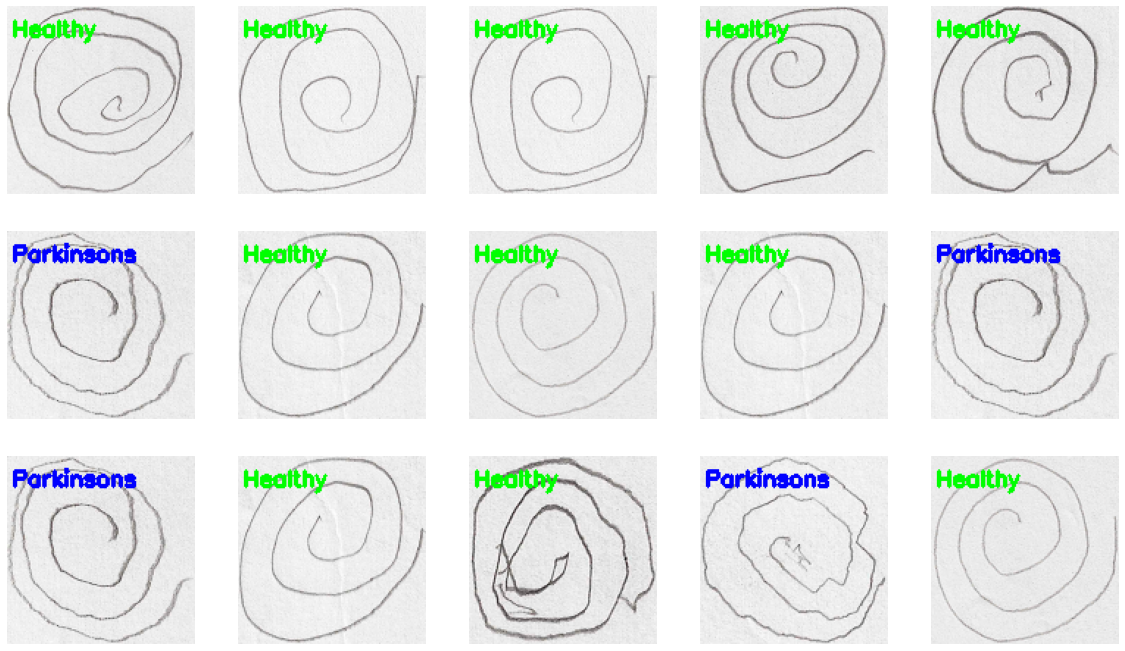

In [76]:
testingPath = os.path.sep.join(["/home/wsuser/work/dataset/spiral", "testing"])
test_prediction(spiralmodels['Rf']['classifier'], testingPath)

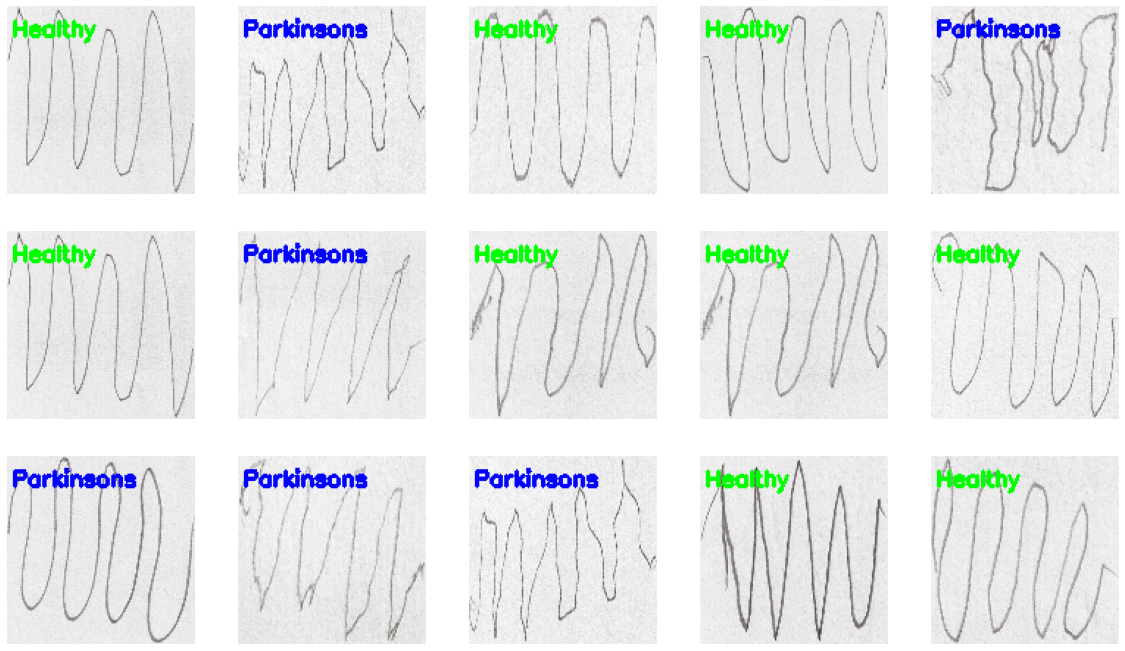

In [78]:
testingPath = os.path.sep.join(["/home/wsuser/work/dataset/wave", "testing"])
test_prediction(wavemodels['Rf']['classifier'], testingPath)

In [79]:
def sprediction(model, testingPath):
  image = cv2.imread(testingPath)


  # pre-process the image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (200, 200))
  image = cv2.threshold(image, 0, 255,
                        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
  preds = model.predict([features])
  label = "Parkinsons" if preds else "Healthy"
  return label

In [81]:
testingPath = os.path.sep.join(["/home/wsuser/work/dataset/spiral", "testing/parkinson/V01PE01.png"])
label=sprediction(spiralmodels['Rf']['classifier'], testingPath)
print(label)

Healthy


In [82]:
!pip install -U ibm-watson-machine-learning

In [83]:
import ibm_watson_machine_learning

In [86]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "apikey":"='######################',-='######################',-='######################',",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [88]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
f8cb8a5a-95c7-4c93-a835-95ad9bdf37a4  pakinsonsetection  2022-11-17T23:56:47.465Z
------------------------------------  -----------------  ------------------------


In [89]:
wml_client.set.default_space("f8cb8a5a-95c7-4c93-a835-95ad9bdf37a4")

'SUCCESS'

In [107]:
MODEL_NAME = 'spiral'
DEPLOYMENT_NAME = 'spiralmodels'
DEMO_MODEL = spiralmodels['Rf']['classifier']

In [108]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

In [109]:
software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [110]:
import sklearn
sklearn.__version__

'1.0.2'

In [111]:
# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [112]:
model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props
)

In [113]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-18T00:17:49.789Z',
  'id': '06edb388-9125-417a-99cc-6e20ae7dc873',
  'modified_at': '2022-11-18T00:17:52.622Z',
  'name': 'spiral',
  'owner': 'IBMid-6630040MWC',
  'resource_key': 'ec20751c-a0fa-4a37-9e9e-507759a64aa4',
  'space_id': 'f8cb8a5a-95c7-4c93-a835-95ad9bdf37a4'},
 'system': {'warnings': []}}

In [114]:
MODEL_NAME = 'wave'
DEPLOYMENT_NAME = 'wavesmodels'
DEMO_MODEL = wavemodels['Rf']['classifier']

In [115]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [117]:
model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props
)

In [118]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-18T00:18:48.956Z',
  'id': '72efc252-c551-4c4d-a01f-854080d6dffb',
  'modified_at': '2022-11-18T00:18:51.063Z',
  'name': 'wave',
  'owner': 'IBMid-6630040MWC',
  'resource_key': '05e96c67-8e9d-48a4-9142-3d3b9ee19bc3',
  'space_id': 'f8cb8a5a-95c7-4c93-a835-95ad9bdf37a4'},
 'system': {'warnings': []}}